In [1]:
#Goal of this notebook: Making a model that can predict the virality of a TikTok video based on its 
# early engagement metrics and metadata.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load training data
df = pd.read_csv("train.csv")

In [3]:
# Check dataset shape
print(f"Dataset shape: {df.shape}")

Dataset shape: (2060, 14)


In [4]:
#from here we can see that 'url, video_id, author_id, author_unique_id, location_created' is not needed for calculation
#also 'description' field is very important, however for the scope of this feature we won't be doing NLP, so we ignore it

In [5]:
df_clean = df[[
    "digg_count",
    "share_count",
    "repost_count",
    "collect_count",
    "comment_count",
    "duration",
    "create_time",
    "play_count"
]].copy()

In [6]:
# Check cleaned data
print(f"Shape: {df_clean.shape}")
print(f"Missing values: {df_clean.isnull().sum().sum()}")

Shape: (2060, 8)
Missing values: 21


In [7]:
#there are only few rows which have missing/null data, we will just remove them because it won't create a significant 
#difference with our result

In [8]:
df_clean = df_clean.dropna()

In [9]:
# Data cleaned - ready for feature engineering

In [10]:
#FEATURE ENGINEERING: create_time has the date time basically, but we want the hour it was posted (cause that's more crucial)

In [11]:
from datetime import datetime

df_clean["upload_hour"] = df_clean["create_time"].apply(
    lambda x: datetime.fromtimestamp(x).hour
)

df_clean = df_clean.drop("create_time", axis=1)


In [12]:
# Verify feature engineering
print(f"Final shape: {df_clean.shape}")
print(f"Upload hour range: {df_clean['upload_hour'].min()} - {df_clean['upload_hour'].max()}")

Final shape: (2057, 8)
Upload hour range: 0 - 23


In [13]:
#We are going to do ratio features (powerful feature engineering)
#Because they show quality of engagement, not just quantity.

#Examples:
# - A video with 100 comments on 1000 likes is strong.
# - A video with 10 comments on 10,000 likes is weak.

In [14]:
df_clean["like_per_comment"] = df_clean["digg_count"] / (df_clean["comment_count"] + 1)
df_clean["share_per_like"] = df_clean["share_count"] / (df_clean["digg_count"] + 1)

# High value → people like but don’t comment → low interaction
# Low value → comments are high relative to likes → high interaction

# High → people share the video more than they like it → viral content
# Low → people don't find it shareable

In [15]:
df_clean = df_clean.drop("repost_count", axis=1)

In [16]:
from sklearn.model_selection import train_test_split

X = df_clean.drop("play_count", axis=1)

# Log transform target to make distribution more normal
y_log = np.log1p(df_clean["play_count"])
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

In [17]:
# Scale features for better model performance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [18]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Train model on log-transformed target
model = LinearRegression()
model.fit(X_train_scaled, y_train_log)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [20]:
# Make predictions and transform back to original scale
preds_log = model.predict(X_test_scaled)
preds = np.expm1(preds_log)
actual = np.expm1(y_test_log)


In [21]:
# Evaluate model performance
r2_log = r2_score(y_test_log, preds_log)
rmse_log = np.sqrt(mean_squared_error(y_test_log, preds_log))

print(f"R2 Score (log space): {r2_log:.4f}")
print(f"RMSE (log space): {rmse_log:.4f}")
print(f"\nNote: R2 in log space ({r2_log:.4f}) is the correct metric since model was trained on log-transformed data.")


R2 Score (log space): 0.4967
RMSE (log space): 0.7875

Note: R2 in log space (0.4967) is the correct metric since model was trained on log-transformed data.


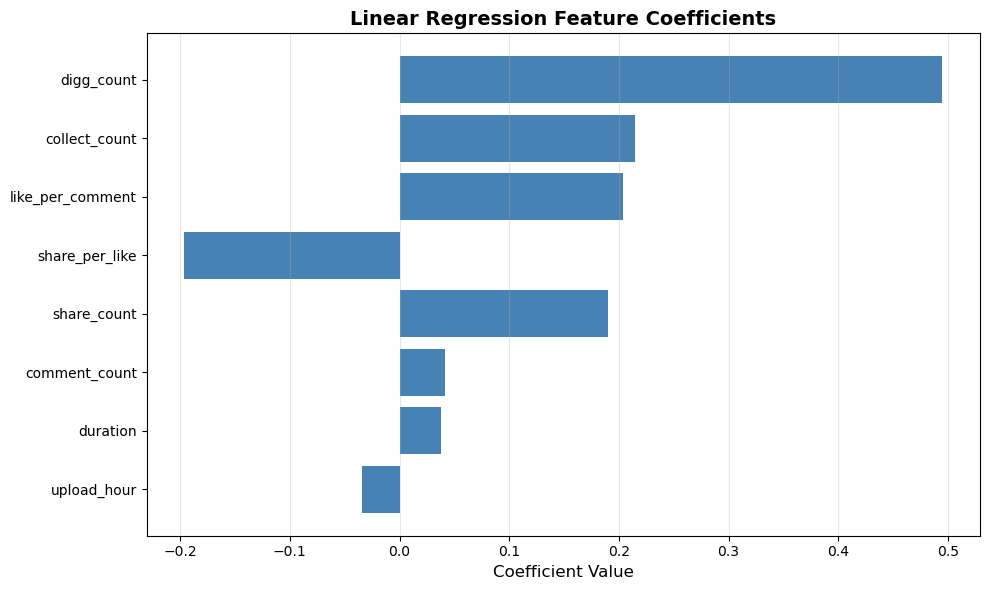

In [22]:
# Feature importance visualization
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['coefficient'], color='steelblue')
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Linear Regression Feature Coefficients', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


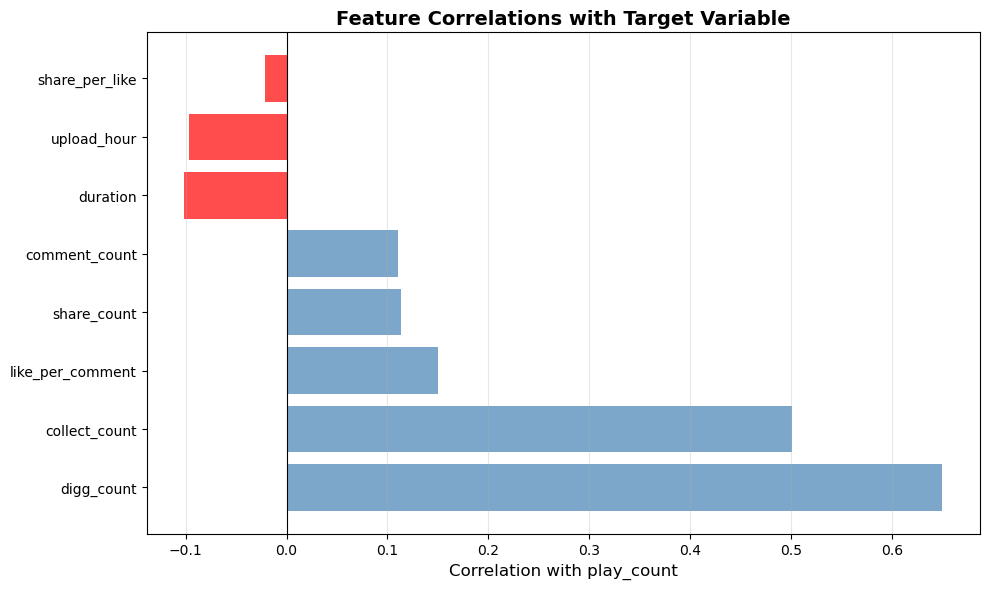

In [23]:
# Feature correlations visualization
correlations = df_clean.corr()['play_count'].sort_values(key=abs, ascending=False)
correlations = correlations.drop('play_count')  # Remove self-correlation

plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'steelblue' for x in correlations.values]
plt.barh(correlations.index, correlations.values, color=colors, alpha=0.7)
plt.xlabel('Correlation with play_count', fontsize=12)
plt.title('Feature Correlations with Target Variable', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()



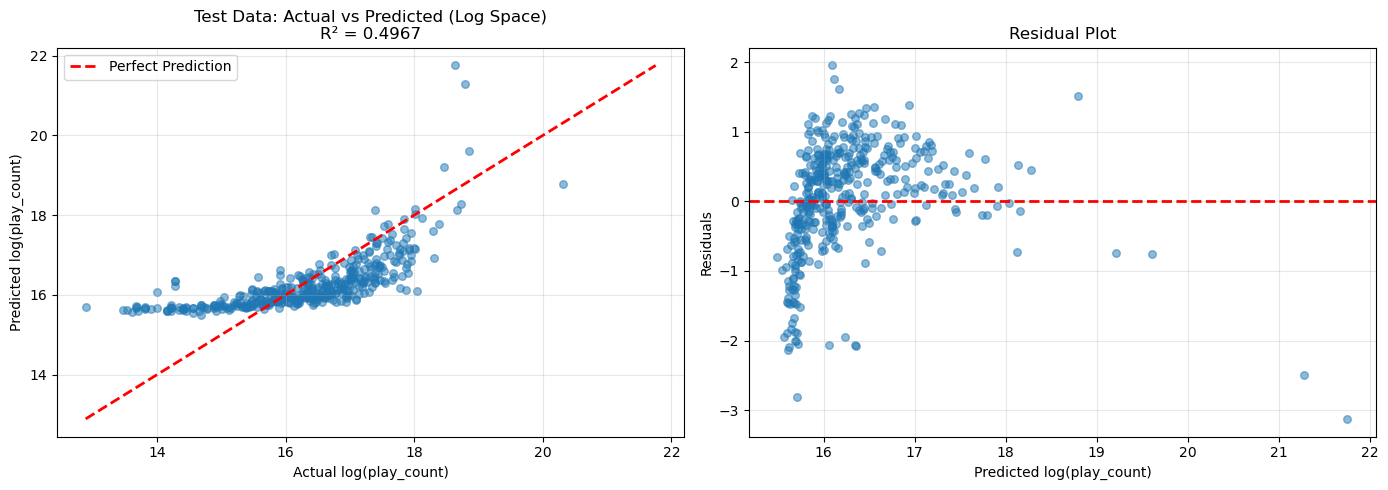

In [24]:
# Visualize model performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Log space (where model was trained)
ax1 = axes[0]
ax1.scatter(y_test_log, preds_log, alpha=0.5, s=30)
min_val = min(y_test_log.min(), preds_log.min())
max_val = max(y_test_log.max(), preds_log.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual log(play_count)')
ax1.set_ylabel('Predicted log(play_count)')
ax1.set_title(f'Test Data: Actual vs Predicted (Log Space)\nR² = {r2_log:.4f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals
ax2 = axes[1]
residuals = y_test_log - preds_log
ax2.scatter(preds_log, residuals, alpha=0.5, s=30)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted log(play_count)')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Plot')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [25]:
# summary
# we did: Linear Regression + log target + feature scaling + proper evaluation in log space
